### **Mutual Information and What it Measures**

In this notebook, we will explore the use of **Mutual Information (MI)** as a metric for feature selection for our further model.

Mutual information describes relationships in terms of uncertainty. The MI between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

MI is similar to correlation, but with the advantage of being able to detect *any* kind of relationship, not just linear ones. Moreover, it is easy to use and interpret, computationally efficient, and theoretically well-founded, and also resistant to overfitting.

So, we will apply MI to our dataset and demonstrate how it can be used to identify the most informative predictors and eliminate the redundant ones, which helps to reduce overfitting and improve the generalization performance of the model. Overall, throughout this notebook, you will gain a better understanding of how MI can be used as a powerful metric for feature selection and its potential to improve the accuracy of our predictions.

In [3]:
import pandas as pd
import numpy as np

import glob

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif

### Loading the data

In [4]:
data_dir = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/'
# 
daily_metadata_file = f'{data_dir}daily_metadata.csv'
defog_metadata_file = f'{data_dir}defog_metadata.csv'
tdcsfog_metadata_file = f'{data_dir}tdcsfog_metadata.csv'
events_data_file = f'{data_dir}events.csv'
subjects_data_file = f'{data_dir}subjects.csv'
tasks_data_file = f'{data_dir}tasks.csv'

# Read the meta data
daily_metadata = pd.read_csv(daily_metadata_file)
defog_metadata = pd.read_csv(defog_metadata_file)
tdcsfog_metadata = pd.read_csv(tdcsfog_metadata_file)
full_metadata = pd.concat([tdcsfog_metadata, defog_metadata])

events_data = pd.read_csv(events_data_file)
subjects_data = pd.read_csv(subjects_data_file)
tasks_data = pd.read_csv(tasks_data_file)

In [5]:
# Read the data and append the Id
def read_data(path):
    df = pd.read_csv(path)
    df['Id'] = path.split("/")[-1].split(".")[0]
    
    return df


# Read and concatenate all files of the train data from specified dataset
def create_full_data(dataset_name):
    paths = glob.glob(data_dir + f'train/{dataset_name}/*')
    final_df = pd.concat([read_data(p) for p in paths])
    final_df['dataset'] = dataset_name
    
    return final_df

In [6]:
# Create a dataframe with all tdcsfog data
tdcsfog_data = create_full_data('tdcsfog')

In [7]:
tdcsfog_data.head(3)

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Id,dataset
0,0,-9.665890,0.042550,0.184744,0,0,0,a171e61840,tdcsfog
1,1,-9.672969,0.049217,0.184644,0,0,0,a171e61840,tdcsfog
2,2,-9.670260,0.033620,0.193790,0,0,0,a171e61840,tdcsfog


In [8]:
# Create a dataframe with all defog data
defog_data = create_full_data('defog')

In [9]:
defog_data.head(3)

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,Id,dataset
0,0,-1.002697,0.022371,0.068304,0,0,0,False,False,be9d33541d,defog
1,1,-1.002641,0.019173,0.066162,0,0,0,False,False,be9d33541d,defog
2,2,-0.999820,0.019142,0.067536,0,0,0,False,False,be9d33541d,defog


In [10]:
defog_data_valid = defog_data.loc[ \
                        (defog_data.Valid == True) & (defog_data.Task == True)].copy()

defog_data_valid.reset_index(drop=True, inplace=True)
defog_data_valid.drop(['Valid', 'Task'], axis=1, inplace=True)

In [11]:
full_data = pd.concat([tdcsfog_data, defog_data_valid])

## Feature engineering

Let's perform some clustering operations on two datasets `tasks_data` and `subjects_data` to extract new features.

For `tasks_data`, we will calculate the duration of each task by subtracting the `Begin` time from the `End` time, and then obtain the sum of durations for each task and each unique `Id` value. Then we will apply a k-means clustering algorithm with 10 clusters on the numeric columns.

For `subjects_data`, we will group the data by `Subject` column and computing the median values for the selected columns. And then we will also apply a k-means clustering algorithm with 10 clusters on the numeric columns.

In [12]:
tasks_data['Duration'] = tasks_data['End'] - tasks_data['Begin']

tasks_data = pd.pivot_table(tasks_data, values=['Duration'],
                                index=['Id'], columns=['Task'],
                                aggfunc='sum', fill_value=0)

tasks_data.columns = [c[-1] for c in tasks_data.columns]
tasks_data = tasks_data.reset_index()

tasks_data['t_kmeans'] = KMeans(n_clusters=10, random_state=42, n_init=10) \
                    .fit_predict(tasks_data[tasks_data.columns[1:]])


subjects_data = subjects_data.fillna(0).groupby('Subject') \
    [['Visit', 'Age', 'YearsSinceDx', 'UPDRSIII_On', 'UPDRSIII_Off', 'NFOGQ']].median() #sample is visit, remove 'Age', YearsSinceDx', 'UPDRSIII_On', 'UPDRSIII_Off', 'NFOGQ'
subjects_data = subjects_data.reset_index()

subjects_data['s_kmeans'] = KMeans(n_clusters=10, random_state=42, n_init=10) \
                    .fit_predict(subjects_data[subjects_data.columns[1:]])

In [13]:
full_data = full_data.merge(full_metadata, on='Id', how='inner') \
                        .merge(tasks_data[['Id','t_kmeans']], how='left', on='Id').fillna(-1) \
                        .merge(subjects_data.drop('Visit', axis=1), #sample is visit
                                       on='Subject', how='left').fillna(-1) #Participant Id is subject
full_data.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Id,dataset,Subject,Visit,Test,Medication,t_kmeans,Age,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ,s_kmeans
0,0,-9.665890,0.042550,0.184744,0,0,0,a171e61840,tdcsfog,8db7dd,2,1.0,off,-1.0,66.0,9.0,38.0,45.0,13.0,5
1,1,-9.672969,0.049217,0.184644,0,0,0,a171e61840,tdcsfog,8db7dd,2,1.0,off,-1.0,66.0,9.0,38.0,45.0,13.0,5
2,2,-9.670260,0.033620,0.193790,0,0,0,a171e61840,tdcsfog,8db7dd,2,1.0,off,-1.0,66.0,9.0,38.0,45.0,13.0,5
3,3,-9.673356,0.035159,0.184369,0,0,0,a171e61840,tdcsfog,8db7dd,2,1.0,off,-1.0,66.0,9.0,38.0,45.0,13.0,5
4,4,-9.671458,0.043913,0.197814,0,0,0,a171e61840,tdcsfog,8db7dd,2,1.0,off,-1.0,66.0,9.0,38.0,45.0,13.0,5


In [14]:
full_data[full_data.dataset == 'defog'].index[0]

7062672

Let's take the first one million rows of the `full_data` dataframe that will correcpond to `tdscfog` dataset rows, and another one million rows (starting from index 7,062,672 to 8,062,672) will be from the `defog` dataset. This will give us a balanced final dataset with equal number of samples from both datasets.

In [15]:
full_data_sample = pd.concat([full_data[:1000_000], full_data[7_062_672:8_062_672]])

In [16]:
full_data_sample.shape

(2000000, 20)

In [17]:
# Create multiclass event type column
full_data_sample['target'] = 'Normal'
targets = ['StartHesitation', 'Turn', 'Walking']
for target in targets:
    full_data_sample.loc[full_data_sample[target] == 1, 'target'] = target
    
full_data_sample.Medication = np.where(full_data_sample.Medication == 'off', 0, 1)

Below we are creating the function that takes a dataframe as input and generates new features based on the AccV, AccML, and AccAP columns. The function returns the original dataframe with the new features appended.

In [18]:
# Create new features based on accelerometer data columns and returns the updated dataframe
def create_features(df):
    acc_cols = ['AccV', 'AccML', 'AccAP']

    for acc in acc_cols:
        df[f'{acc}_lag_2'] = df.groupby('Id')[acc].shift(2).fillna(method="backfill")
        df[f'{acc}_lag_3'] = df.groupby('Id')[acc].shift(3).fillna(method="backfill")
        df[f'{acc}_lag_4'] = df.groupby('Id')[acc].shift(4).fillna(method="backfill")
        df[f'{acc}_lag_5'] = df.groupby('Id')[acc].shift(5).fillna(method="backfill")

        df[f'{acc}_cumsum'] = (df[acc]).groupby(df['Id']).cumsum()

        df[f'{acc}_first_value'] = df.groupby('Id')[acc].transform('first')
        df[f'{acc}_last_value'] = df.groupby('Id')[acc].transform('last')

        df[f'{acc}_mean'] = df.groupby('Id')[acc].transform('mean')
        df[f'{acc}_median'] = df.groupby('Id')[acc].transform('median')
        df[f'{acc}_std'] = df.groupby('Id')[acc].transform('std')

        df[f'{acc}_min'] = df.groupby('Id')[acc].transform('min')
        df[f'{acc}_max'] = df.groupby('Id')[acc].transform('max')

        df[f'{acc}_delta'] = df[f'{acc}_max'] - df[f'{acc}_min']
        for lag in [1,2,3]:
            df[f'ma_{lag}_{acc}'] = df[acc].rolling(lag).mean().fillna(method="backfill")
            df[f'ma{lag}_{acc}'] = df[acc].rolling(lag).mean().fillna(method="backfill")
            df[f'ma_{lag}_{acc}'] = df[acc].rolling(lag).mean().fillna(method="backfill")
        
    return df

In [19]:
# Apply the above function to our dataset
full_data_sample = create_features(full_data_sample)

In [20]:
# Assign variables with predictors and target
X = full_data_sample.drop(['Id', 'dataset', 'Test', 'Subject', 'UPDRSIII_Off',
                               'StartHesitation', 'Turn', 'Walking'], axis=1).copy()
y = X.pop('target')

In [21]:
# Check the missing values in our X dataset
X.isna().sum()[X.isna().sum() > 0]

Series([], dtype: int64)

In [22]:
# Check the categorical variables in our X dataset
X.dtypes[X.dtypes == object]

Series([], dtype: object)

### Calculating Mutual information scores

In [23]:
discrete_features = X.dtypes == int

# Calculate MI scores for the features in X with respect to the target variable y
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# Apply this function to our data
mi_scores = make_mi_scores(X, y, discrete_features)

In [24]:
# Show 10 features with the highest MI score
mi_scores.to_frame().head(10)

,MI Scores
AccML_max,0.322081
AccV_delta,0.321847
AccV_median,0.321826
AccML_min,0.321817
AccAP_delta,0.321686
AccV_last_value,0.321674
AccML_delta,0.321641
AccAP_min,0.321640
AccV_min,0.321404
AccV_std,0.321241


Let's plot a bar plot to make comparisions easier.

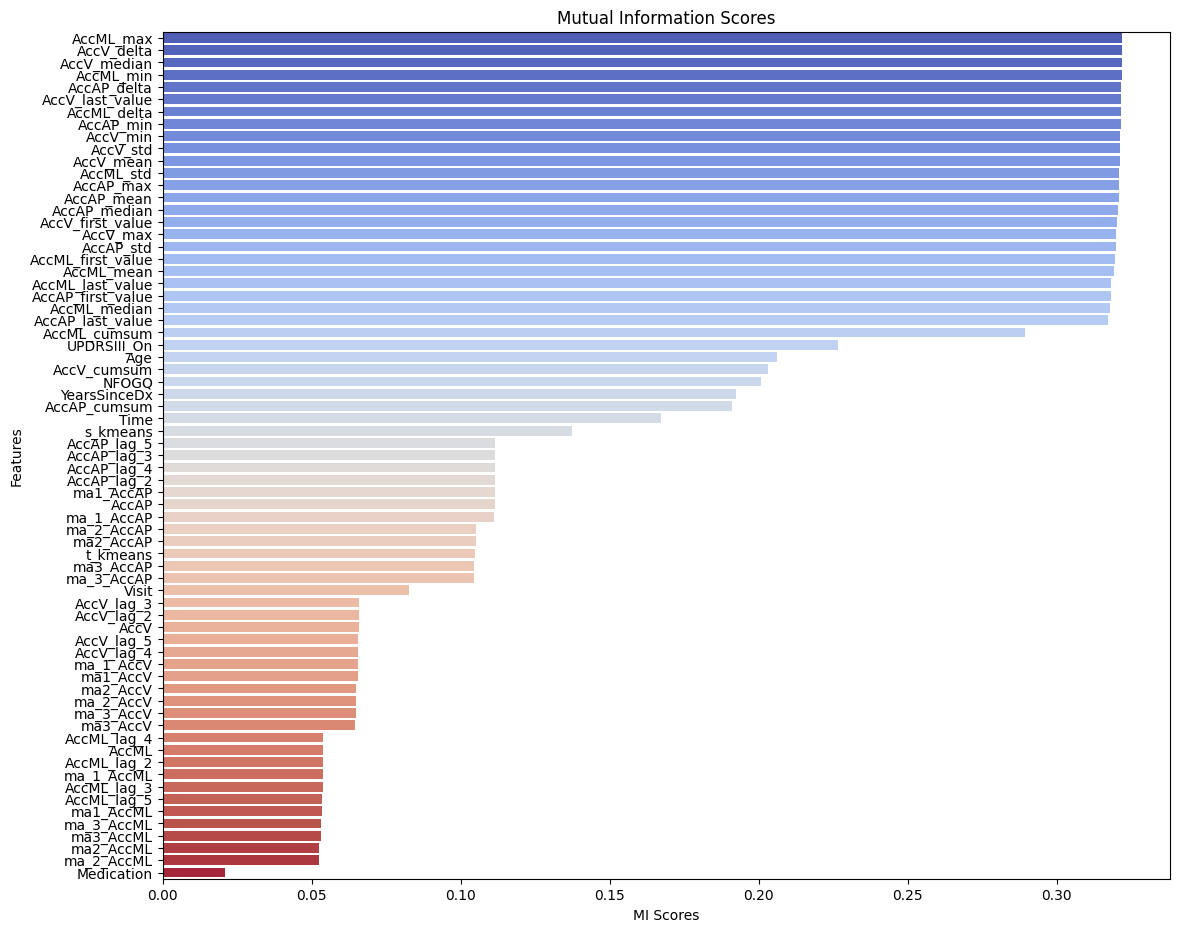

In [25]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(13, 11))
    ax = sns.barplot(x=scores.values, y=scores.index, palette="coolwarm", orient='h')
    ax.set_title("Mutual Information Scores")
    ax.set_xlabel("MI Scores")
    ax.set_ylabel("Features")
    plt.show()

plot_mi_scores(mi_scores)
plt.show()

So, as we can see from the above plot the most relevant features for our further model are:
- the difference between the maximum and minimum values of all accelerometer data columns: `AccV_delta`, `AccAP_delta`, `AccML_delta`,
- the minimum and maximum values of the accelerometer columns, especially `AccML_min`, `AccAP_min`, `AccML_max`, 
- the mean, median, and standard deviation of the columns, especially `AccV_median`, `AccV_mean`, `AccV_std`,
- the first and last values of the columns, especially `AccV_last_value`,
- the cumulative sum of the accelerometer data columns.
 
Other highly informative features include `Age`, `UPDRSIII_On`, and `NFOGQ` which respectively represent the age of patients, the motor score of patients when taking medication, and the presence of freezing of gait.

On the other hand, the most uninformative features are the `Medication` status column, the moving average features using the rolling method such as `ma_2_AccML`, and the lagged versions of accelerometer data, such as `AccML_lag_3`. These features do not seem to have a strong relationship with the target variable and may not be useful in predicting it.

Overall, these results can guide us in selecting the most relevant features for building our predictive model.